In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

Считывание тренировочных данных (файл должен находиться в текущей директории).

In [2]:
data_train = pd.read_csv('train.csv')
data_train.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0
5,5,Female,31,1,47.0,1,< 1 Year,No,28150.0,152.0,197,0
6,6,Male,23,1,45.0,1,< 1 Year,No,27128.0,152.0,190,0
7,7,Female,47,1,8.0,0,1-2 Year,Yes,40659.0,26.0,262,1
8,8,Female,26,1,28.0,1,< 1 Year,No,31639.0,152.0,36,0
9,9,Female,66,1,11.0,0,1-2 Year,Yes,2630.0,26.0,125,0


1. Response (таргет)

Тип: Бинарная переменная (dichotomous).

Значение: Ответ респондента. Показывает будет ли клиент страховать автомобиль, на уровне заинтересованности:
- 1 — заинтересован,
- 0 — не заинтересован.

Комментарий: Целевая переменная, которую предсказывает модель.

2. Gender

Тип: Категориальный признак (nominal).

Значение: Пол клиента:
- Male — Мужчина,
- Female — Женщина.

Комментарий: Преобразуем в бинарный:
- 1 - Male,
- 0 - Female.

3. Age

Тип: Числовой признак (continous).

Значение: Возраст клиента, в годах.

Комментарий: Требует нормализации.

4. Driving_License

Тип: Бинарный признак (dichotomous).

Значение: Наличие водительского удостоверения:
- 1 — имеется,
- 0 — отсутствует.

Комментарий: Наверняка будет играть значимое влияние на решение страховать автомобиль.

5. Region_Code

Тип: Категориальный признак (nominal).

Значение: Уникальный код региона клиента.

Комментарий: Делаем one-hot????

6. Previously_Insured

Тип: Бинарный признак (dichotomous).

Значение: Наличие страховки ранее:
- 1 - имелась,
- 0 - отсутствовала.

Комментарий: Потенциально может характеризовать склонность страховать снова.

7. Vehicle_Age

Тип: Категориальный признак (nominal).

Значение: Возраст транспортного средства.

Комментарий: Нормировка или one-hot???

8. Vehicle_Damage

Тип: Категориальный признак (nominal).

Значение: Повреждение транпортного средства ранее:
- Yes - имелось повреждение,
- No - отсутствовало повреждение.

Комментарий: Преобразуем в бинарный (dichotomous):
- 1 - имелось повреждение,
- 0 - отсутствовало повреждение.

9. Annual_Premium

Тип: Числовой признак (continous).

Значение: Ежегодный платеж клиента.

Комментарий: Требует нормализации.

10. Policy_Sales_Channel

Тип: Категориальный признак (nominal).

Значение: Код, соответсвующий каналу выхода на клиента. Например, по телефону, при личной встрече и др. Конкетное соответствие числам неизвестно.

Комментарий: Непонятно что с ним делать.

11. Vintage

Тип: Числовой признак (continous).

Значение: Количество дней, в течение которых является клиентом компании.

Комментарий: Требует нормализации.

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000001 entries, 0 to 5000000
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 457.8+ MB


Проверка пустых значений.

In [4]:
data_train.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Пустых значений нет.

Уникальные значения в столбце 'Vehicle_Age':

In [5]:
data_train['Vehicle_Age'].unique()

array(['1-2 Year', '> 2 Years', '< 1 Year'], dtype=object)

Преобразование признаков

In [6]:
# Признак 'Vehicle_Age' (nominal) заменяем на числовой (continous):
# 0 - '< 1 Year'
# 1 - '1-2 Year'
# 2 - '> 2 Years'
Vehicle_Age_category = ['< 1 Year', '1-2 Year', '> 2 Years']
Vehicle_Age_number = list(range(len(Vehicle_Age_category)))
for idx, column_name in enumerate(Vehicle_Age_category):
    data_train['Vehicle_Age'] = data_train['Vehicle_Age'].apply(lambda x: Vehicle_Age_number[idx] if x == column_name else x)

# Признак 'Gender' (nominal) заменяем на 'Is_Male' (dichotomous): 1 - Male, 0 - Female.
data_train['Gender'] = data_train['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
data_train.rename(columns={'Gender': 'Is_Male'}, inplace=True)

# Признак 'Vehicle_Damage' (nominal) заменяем на (dichotomous): 1 - Yes, 0 - No.
data_train['Vehicle_Damage'] = data_train['Vehicle_Damage'].apply(lambda x: 1 if x == 'Yes' else 0)

Преобразование float-признаков в целочисленный тип (int64). С целью дальнейшей группировки по значениям.

In [7]:
int_columns = ['Region_Code', 'Policy_Sales_Channel']
for col_name in int_columns:
    data_train[col_name] = data_train[col_name].astype('int64')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000001 entries, 0 to 5000000
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Is_Male               int64  
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           int64  
 5   Previously_Insured    int64  
 6   Vehicle_Age           int64  
 7   Vehicle_Damage        int64  
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  int64  
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(1), int64(11)
memory usage: 457.8 MB


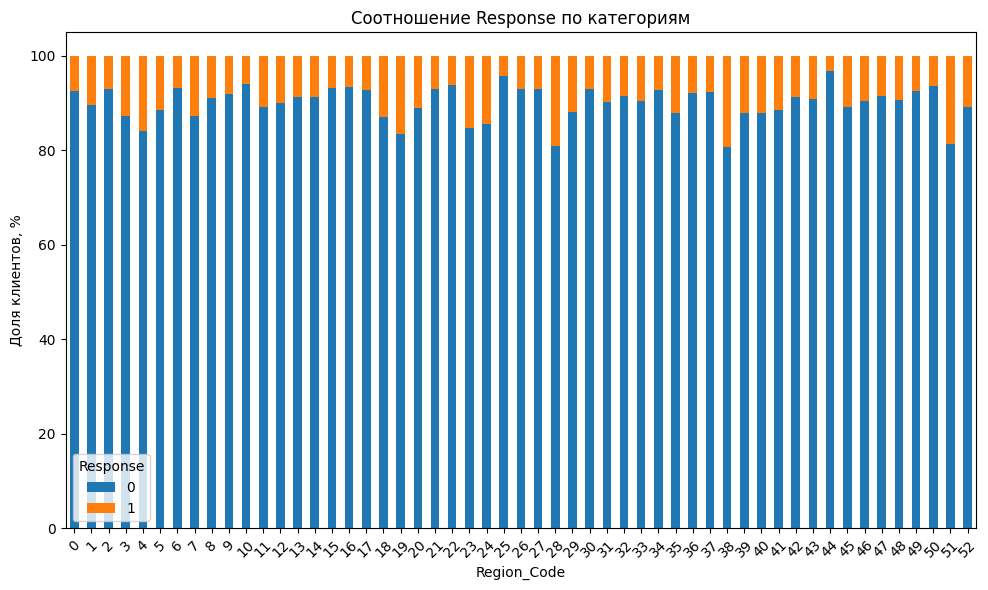

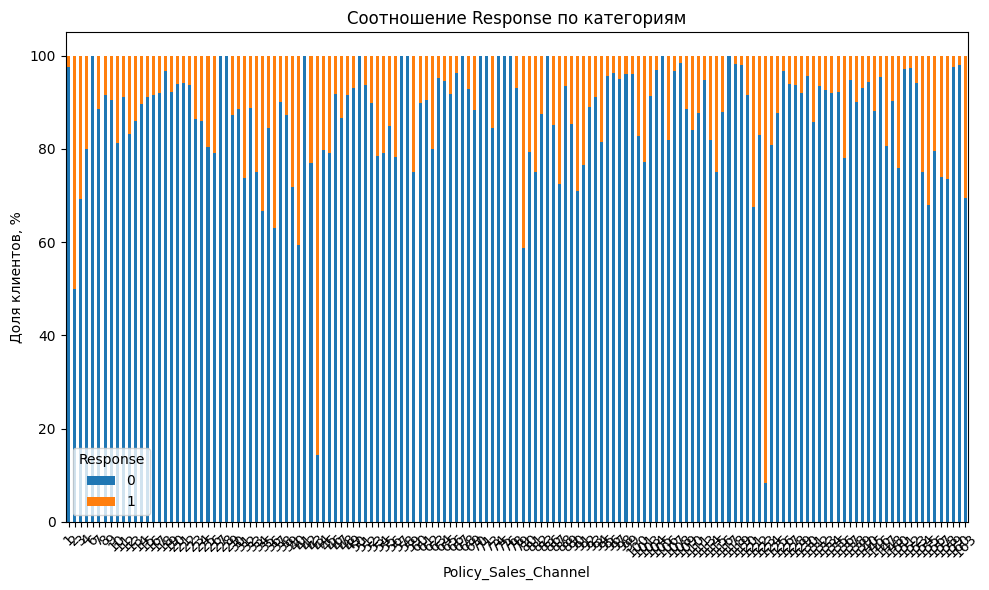

In [8]:
def plot_response_ratio(feature):
    # Группируем данные и считаем процентное соотношение Response
    data_ratio = data_train.groupby(feature)['Response'].value_counts(normalize=True).unstack().fillna(0) * 100
    #print(data_ratio.mean())
    #print(data_ratio.std())
    # Построение гистограммы
    data_ratio.plot(kind='bar', stacked=True, figsize=(10, 6))
    
    # Настройка графика
    plt.title('Соотношение Response по категориям')
    plt.xlabel(feature)
    plt.ylabel('Доля клиентов, %')
    plt.xticks(rotation=45)
    plt.legend(title='Response', labels=['0', '1'])
    plt.tight_layout()
    plt.show()

# Применим функцию к данным.
plot_response_ratio('Region_Code')
plot_response_ratio('Policy_Sales_Channel')

Удаляем бесполезные признаки.

In [9]:
columns_to_remove = ['id', 'Region_Code', 'Policy_Sales_Channel', 'Driving_License', 'Annual_Premium', 'Vintage']
data_train = data_train.drop(columns=columns_to_remove)
data_train.head(10)

,Is_Male,Age,Previously_Insured,Vehicle_Age,Vehicle_Damage,Response
0,1,21,0,1,1,0
1,1,43,0,2,1,1
2,0,25,1,0,0,0
3,0,35,0,1,1,0
4,0,36,1,1,0,0
5,0,31,1,0,0,0
6,1,23,1,0,0,0
7,0,47,0,1,1,1
8,0,26,1,0,0,0
9,0,66,0,1,1,0


In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000001 entries, 0 to 5000000
Data columns (total 6 columns):
 #   Column              Dtype
---  ------              -----
 0   Is_Male             int64
 1   Age                 int64
 2   Previously_Insured  int64
 3   Vehicle_Age         int64
 4   Vehicle_Damage      int64
 5   Response            int64
dtypes: int64(6)
memory usage: 228.9 MB


Матрица корреляций.

<Axes: >

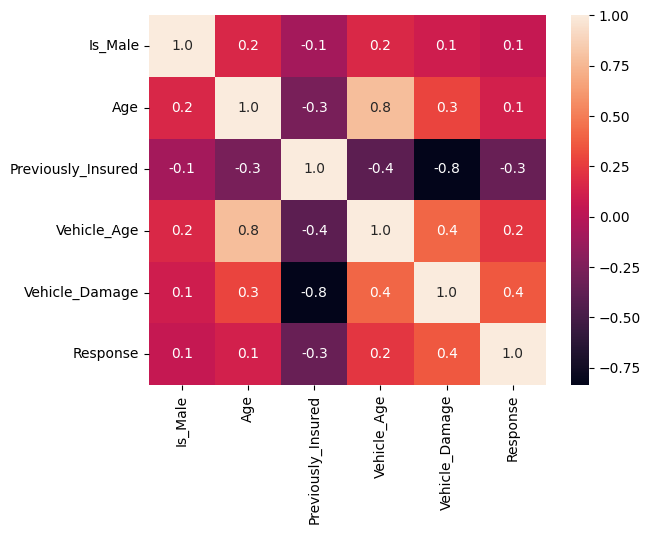

In [11]:
sns.heatmap(data_train.corr(), annot=True, fmt = '.1f')

Наблюдается высокая корреляция следующих признаков:
- 'Age' - 'Vehicle_Age' - положительная,
- 'Previously_Insured' - 'Vehicle_Damage' - отрицательная.

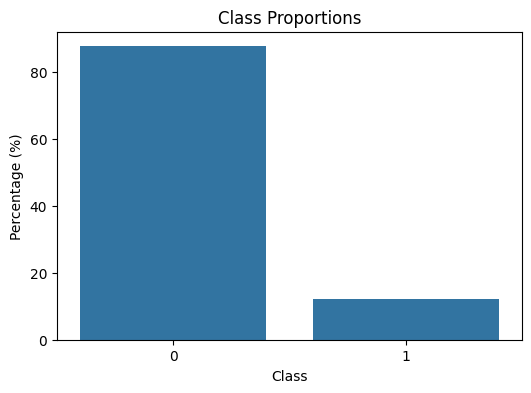

In [12]:
# Визуализация пропорций классов
class_proportions = data_train['Response'].value_counts(normalize=True)

plt.figure(figsize=(6, 4))
sns.barplot(x=class_proportions.index, y=class_proportions.values * 100)
plt.title('Class Proportions')
plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.show()

Норммировка данных по типу 'StandardScaler', балансировка классов (SMOTE), разделение на датафреймы:
- X_train - признаки,
- y_train - отклик (таргет).

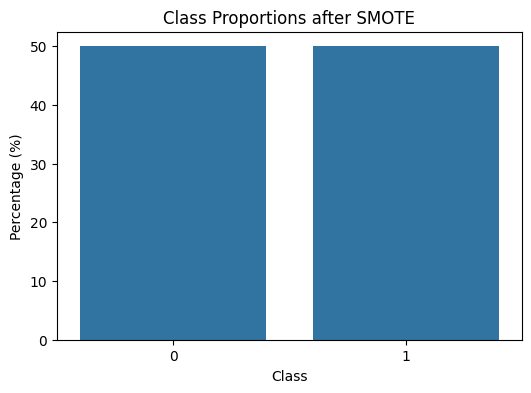

In [13]:
random_state_user = 5

standard_scaler = StandardScaler()

tmp_X_train = data_train.drop(columns=['Response'])
X_train = pd.DataFrame(standard_scaler.fit_transform(tmp_X_train.values), columns=tmp_X_train.columns)
y_train = data_train['Response']

# Применим SMOTE для балансировки классов.
model_smote = SMOTE(random_state=random_state_user)
X_train, y_train = model_smote.fit_resample(X_train.values, y_train.values)
X_train = pd.DataFrame(X_train, columns=data_train.drop(columns=['Response']).columns)

# Снова проверим пропорции классов.
y_train = pd.DataFrame(y_train, columns=['Response'])
class_proportions_smote = y_train['Response'].value_counts(normalize=True)

plt.figure(figsize=(6, 4))
sns.barplot(x=class_proportions_smote.index, y=class_proportions_smote.values * 100)
plt.title('Class Proportions after SMOTE')
plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.show()

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8769440 entries, 0 to 8769439
Data columns (total 5 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Is_Male             float64
 1   Age                 float64
 2   Previously_Insured  float64
 3   Vehicle_Age         float64
 4   Vehicle_Damage      float64
dtypes: float64(5)
memory usage: 334.5 MB


In [17]:
f1_pos = make_scorer(f1_score, pos_label=1, average='binary')

# 1. Decision Tree
'''
tree_param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 2, 3],
    'criterion': ['gini', 'entropy']
}
'''
# Best parameters:
tree_param_grid = {'criterion': ['gini'], 'max_depth': [10], 'min_samples_leaf': [2], 'min_samples_split': [5]}

tree_model = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=random_state_user),
    param_grid=tree_param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring=f1_pos
)
tree_model.fit(X_train.values, y_train.values)
'''
# 2. Random Forest
rf_param_grid = {'n_estimators': [10, 50, 100, 200], 'max_depth': [5, 10, 15], 'min_samples_split': [3, 5, 10], 'random_state': [5, 103]}
rf_model = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=3, n_jobs=-1, verbose=2, scoring=f1_pos)
rf_model.fit(X_train.values, y_train.values)

# 3. LogisticRegression
logreg_param_grid = {
    'penalty': [None, 'l1', 'l2']
}
logreg_setup = LogisticRegression(C=1.0, solver='liblinear', class_weight='balanced', max_iter=100)
logreg_model = GridSearchCV(logreg_setup, logreg_param_grid, cv=3, n_jobs=-1, verbose=2, scoring=f1_pos)
logreg_model.fit(X_train.values, y_train.values)

# 4. Support Vector Machine (SVM)
#svm_param_grid = {'kernel': ['linear', 'rbf', 'sigmoid']}
svm_param_grid = {'kernel': ['rbf']}
svm_model = GridSearchCV(SVC(C=1.0, random_state = random_state_user), svm_param_grid, cv=2, n_jobs=-1, verbose=2, scoring=f1_pos)
svm_model.fit(X_train.values, y_train.values)

# 5. Bagging.
#bagging_param_grid = {'max_samples': [0.1, 0.3], 'random_state': [5, 103]}
bagging_setup = BaggingClassifier(DecisionTreeClassifier(class_weight='balanced'), n_estimators=20, max_features=1.0)
bagging_model = GridSearchCV(bagging_setup, bagging_param_grid, cv=3, n_jobs=-1, verbose=2, scoring=f1_pos)
bagging_model.fit(X_train.values, y_train.values.ravel())
bagging_model_best = bagging_model.best_estimator_
'''

Fitting 3 folds for each of 1 candidates, totalling 3 fits


"\n# 2. Random Forest\nrf_param_grid = {'n_estimators': [10, 50, 100, 200], 'max_depth': [5, 10, 15], 'min_samples_split': [3, 5, 10], 'random_state': [5, 103]}\nrf_model = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=3, n_jobs=-1, verbose=2, scoring=f1_pos)\nrf_model.fit(X_train.values, y_train.values)\n\n# 3. LogisticRegression\nlogreg_param_grid = {\n    'penalty': [None, 'l1', 'l2']\n}\nlogreg_setup = LogisticRegression(C=1.0, solver='liblinear', class_weight='balanced', max_iter=100)\nlogreg_model = GridSearchCV(logreg_setup, logreg_param_grid, cv=3, n_jobs=-1, verbose=2, scoring=f1_pos)\nlogreg_model.fit(X_train.values, y_train.values)\n\n# 4. Support Vector Machine (SVM)\n#svm_param_grid = {'kernel': ['linear', 'rbf', 'sigmoid']}\nsvm_param_grid = {'kernel': ['rbf']}\nsvm_model = GridSearchCV(SVC(C=1.0, random_state = random_state_user), svm_param_grid, cv=2, n_jobs=-1, verbose=2, scoring=f1_pos)\nsvm_model.fit(X_train.values, y_train.values)\n\n# 5. Bagging.\n#baggi

In [18]:
clf_model_best = tree_model

In [19]:
clf_model_best

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [10],
                         'min_samples_leaf': [2], 'min_samples_split': [5]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=1, average=binary),
             verbose=2)

Сохранение моделей в файл.

In [ ]:

import pickle

model_filename = "clf_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(clf_model_best, file)
print(f"Модель классификатора сохранена в файл: {model_filename}")

model_filename = "sc_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(standard_scaler, file)
print(f"Модель нормализатора сохранена в файл: {model_filename}")

Модель классификатора сохранена в файл: clf_model1.pkl


'\nmodel_filename = "sc_model.pkl"\nwith open(model_filename, \'wb\') as file:\n    pickle.dump(standard_scaler, file)\nprint(f"Модель нормализатора сохранена в файл: {model_filename}")\n'